In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-classification-dataset/tweet_sentiment.csv


In [59]:
!pip install deep-translator
!pip install nltk
!pip install wordcloud

In [61]:
import pandas as pd
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from deep_translator import GoogleTranslator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from collections import Counter

In [45]:
# Carregar o dataset diretamente do Kaggle (já deve estar disponível no ambiente do notebook)
df = pd.read_csv('/kaggle/input/tweet-sentiment-classification-dataset/tweet_sentiment.csv')

# Verificar as primeiras linhas do dataset
df

,tweet,sentiment
0,The event starts at 5 PM.,neutral
1,I hate how this turned out.,negative
2,Fantastic experience!,positive
3,Fantastic experience!,positive
4,This is the worst thing ever!,negative
...,...,...
995,It’s cloudy outside.,neutral
996,Great job by the team!,positive
997,I'm so happy about the news!,positive
998,It ruined my whole day.,negative


In [46]:
# Traduzir sentimentos com dicionário (já está feito!)
sentiment_map = {
    "positive": "positivo",
    "negative": "negativo",
    "neutral": "neutro"
}

df['sentimento'] = df['sentiment'].map(sentiment_map)

# Traduzir tweets
df['tweet_pt'] = df['tweet'].apply(lambda x: GoogleTranslator(source='auto', target='pt').translate(x))

df = df.drop(['tweet', 'sentiment'], axis=1)

# Visualizar
df

,sentimento,tweet_pt
0,neutro,O evento começa às 17h.
1,negativo,Eu odeio como isso acabou.
2,positivo,Experiência fantástica!
3,positivo,Experiência fantástica!
4,negativo,Esta é a pior coisa de todos os tempos!
...,...,...
995,neutro,Está nublado lá fora.
996,positivo,Ótimo trabalho da equipe!
997,positivo,Estou tão feliz com as notícias!
998,negativo,Isso arruinou meu dia inteiro.


In [47]:
# Verificar o tipo de dados e valores ausentes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentimento  1000 non-null   object
 1   tweet_pt    1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None


In [48]:
# Contar a distribuição das classes de sentimento (positivo/negativo)
print(df['sentimento'].value_counts())

sentimento
positivo    396
neutro      317
negativo    287
Name: count, dtype: int64


In [49]:
# Analisar as estatísticas básicas (ex: média, desvio padrão)
print(df.describe())

       sentimento                 tweet_pt
count        1000                     1000
unique          3                       17
top      positivo  Experiência fantástica!
freq          396                       71


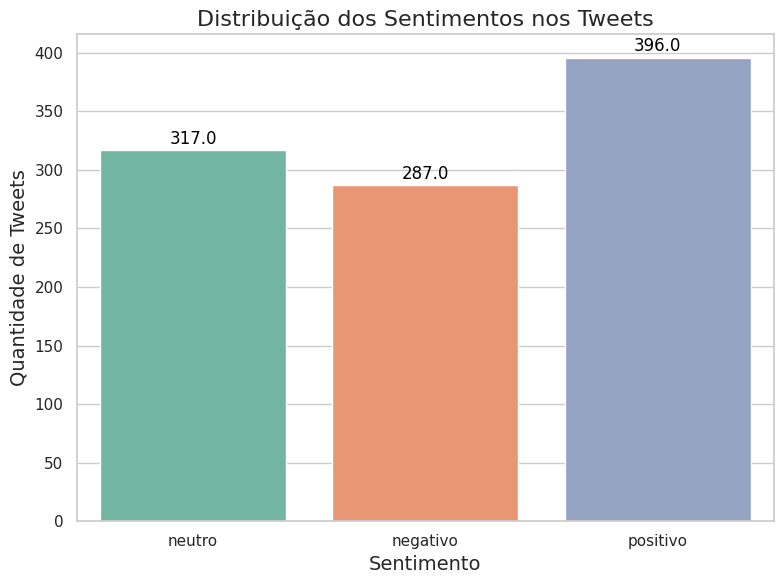

In [80]:
# Definir o estilo do gráfico
sns.set(style="whitegrid")

# Criar o gráfico de contagem
plt.figure(figsize=(8, 6))  # Ajustar o tamanho da figura
ax = sns.countplot(data=df, x='sentimento', palette='Set2')

# Adicionar o título e rótulos aos eixos
plt.title('Distribuição dos Sentimentos nos Tweets', fontsize=16)
plt.xlabel('Sentimento', fontsize=14)
plt.ylabel('Quantidade de Tweets', fontsize=14)

# Adicionar a contagem acima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Ajustar o layout para garantir que todos os elementos estejam visíveis
plt.tight_layout()

# Exibir o gráfico
plt.show()

### Identificar as palavras mais comuns dentro de cada categoria de sentimento (positivo, negativo e neutro) nos tweets
##### O que o código identifica
##### Positivo: As 10 palavras mais comuns entre os tweets classificados como "positivo".
##### Negativo: As 10 palavras mais comuns entre os tweets classificados como "negativo".
##### Neutro: As 10 palavras mais comuns entre os tweets classificados como "neutro".

In [76]:
def get_common_words(df, label):
    words = ' '.join(df[df['sentimento'] == label]['cleaned_text']).split()
    return Counter(words).most_common(10)

print("🟢 Positivo:", get_common_words(df, 'positivo'))
print("🔴 Negativo:", get_common_words(df, 'negativo'))
print("🟡 Neutro:", get_common_words(df, 'neutro'))

🟢 Positivo: [('dia', 129), ('experi', 71), ('fant', 71), ('absolut', 69), ('ame', 69), ('tão', 67), ('feliz', 67), ('notíc', 67), ('atual', 66), ('fez', 66)]
🔴 Negativo: [('odei', 54), ('acab', 54), ('decepcion', 53), ('result', 53), ('decis', 51), ('tão', 51), ('terr', 51), ('cans', 50), ('diss', 50), ('acontec', 50)]
🟡 Neutro: [('event', 69), ('começ', 69), ('trabalh', 67), ('cas', 67), ('nov', 67), ('hoj', 66), ('nubl', 63), ('lá', 63), ('acab', 52), ('ler', 52)]


###  Pré-processamento de Texto

In [50]:
# Baixar recursos necessários do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

# Inicializar lematizador e stopwords
stemmer = RSLPStemmer()
stop_words = set(stopwords.words('portuguese'))

# Função para pré-processar os tweets em português
def preprocess_text(text):
    # Remover URLs
    text = re.sub(r'http\S+', '', text)
    # Tokenizar
    words = word_tokenize(text.lower())
    # Remover stopwords e aplicar stemming
    words = [stemmer.stem(w) for w in words if w not in stop_words and w.isalpha()]
    return ' '.join(words)

# Aplicar o pré-processamento nos tweets traduzidos
df['cleaned_text'] = df['tweet_pt'].apply(preprocess_text)

# Visualizar resultado
print(df[['tweet_pt', 'cleaned_text']])

                                    tweet_pt        cleaned_text
0                    O evento começa às 17h.         event começ
1                 Eu odeio como isso acabou.           odei acab
2                    Experiência fantástica!         experi fant
3                    Experiência fantástica!         experi fant
4    Esta é a pior coisa de todos os tempos!    pi cois tod temp
..                                       ...                 ...
995                    Está nublado lá fora.             nubl lá
996                Ótimo trabalho da equipe!  ótim trabalh equip
997         Estou tão feliz com as notícias!     tão feliz notíc
998           Isso arruinou meu dia inteiro.      arruin dia int
999         Estou cansado disso acontecendo.   cans diss acontec

[1000 rows x 2 columns]


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /usr/share/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### Nuvem de palavras - Wordcloud

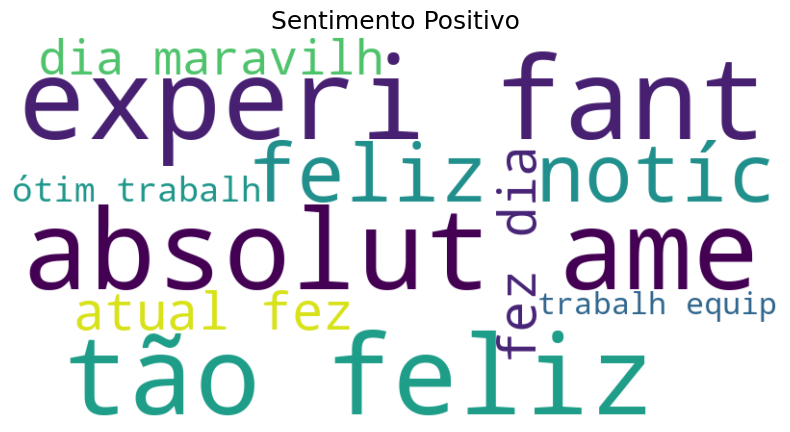

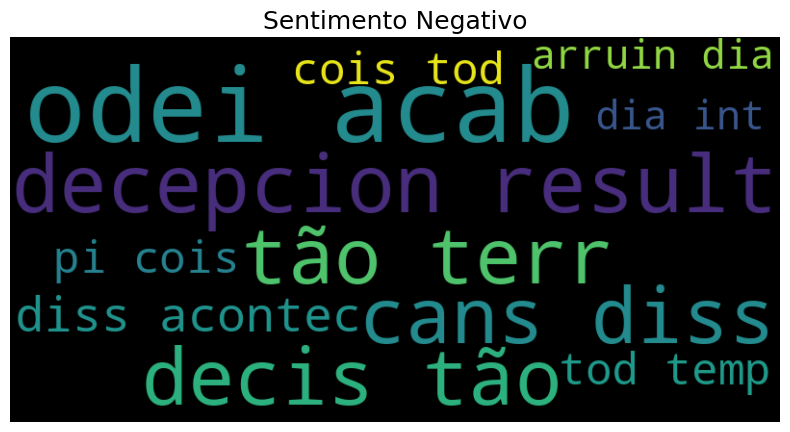

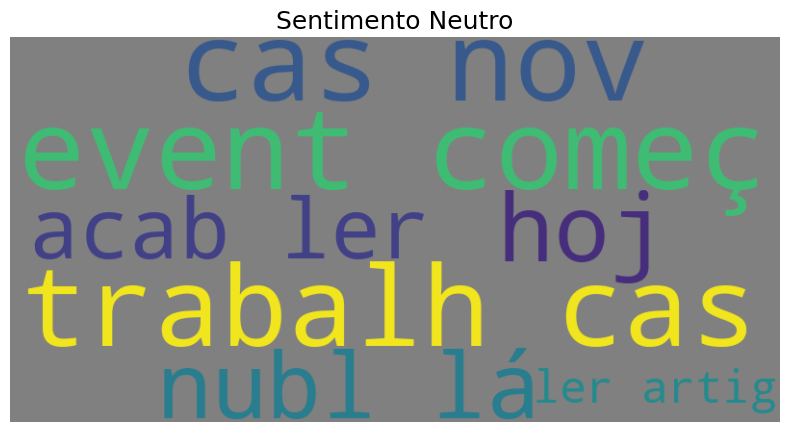

In [62]:
# Gerar as nuvens de palavras para cada sentimento
texto_positivo = ' '.join(df[df['sentimento'] == 'positivo']['cleaned_text'])
texto_negativo = ' '.join(df[df['sentimento'] == 'negativo']['cleaned_text'])
texto_neutro = ' '.join(df[df['sentimento'] == 'neutro']['cleaned_text'])

def gerar_wordcloud(texto, cor_fundo, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color=cor_fundo).generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=18)
    plt.show()

gerar_wordcloud(texto_positivo, 'white', 'Sentimento Positivo')
gerar_wordcloud(texto_negativo, 'black', 'Sentimento Negativo')
gerar_wordcloud(texto_neutro, 'gray', 'Sentimento Neutro')

### Vetorização do Texto

In [95]:
# Vetorização dos textos
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['sentimento']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
print(X_train.shape, X_test.shape)
print(len(set(y_train)), len(set(y_test)))

(800, 38) (200, 38)
3 3


In [82]:
print(f"Número de palavras únicas (features): {len(vectorizer.get_feature_names_out())}")

Número de palavras únicas (features): 38


# Naive Bayes

Naive Bayes - Classification Report:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00        55
      neutro       1.00      1.00      1.00        67
    positivo       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



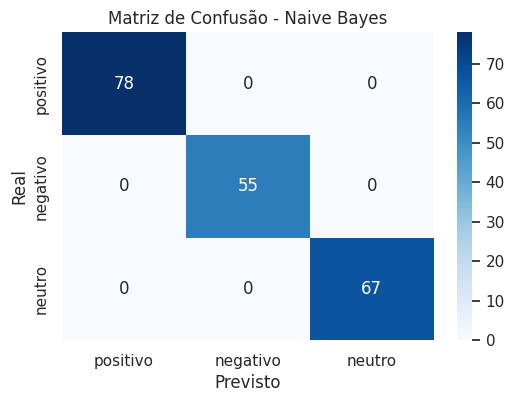

In [96]:
# Instanciar e treinar o modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Previsões
y_pred = nb_model.predict(X_test)

# Exibir métricas de avaliação
print("Naive Bayes - Classification Report:")
print(classification_report(y_test, y_pred))

# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=['positivo', 'negativo', 'neutro'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positivo', 'negativo', 'neutro'],
            yticklabels=['positivo', 'negativo', 'neutro'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Naive Bayes')
plt.show()

# SVM (Support Vector Machine)

SVM - Classification Report:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00        55
      neutro       1.00      1.00      1.00        67
    positivo       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



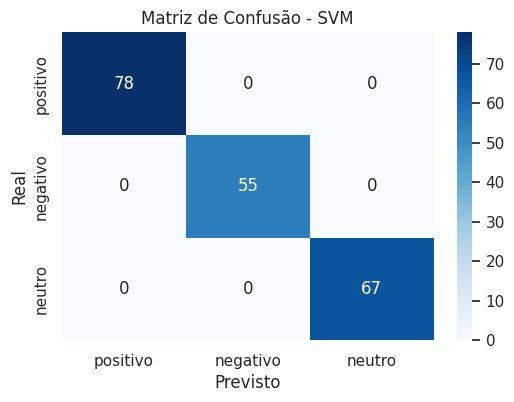

In [97]:
# Instanciar e treinar o modelo SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Previsões
y_pred = svm_model.predict(X_test)

# Exibir métricas de avaliação
print("SVM - Classification Report:")
print(classification_report(y_test, y_pred))

# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=['positivo', 'negativo', 'neutro'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positivo', 'negativo', 'neutro'],
            yticklabels=['positivo', 'negativo', 'neutro'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - SVM')
plt.show()

# Random Forest

Random Forest - Classification Report:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00        55
      neutro       1.00      1.00      1.00        67
    positivo       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



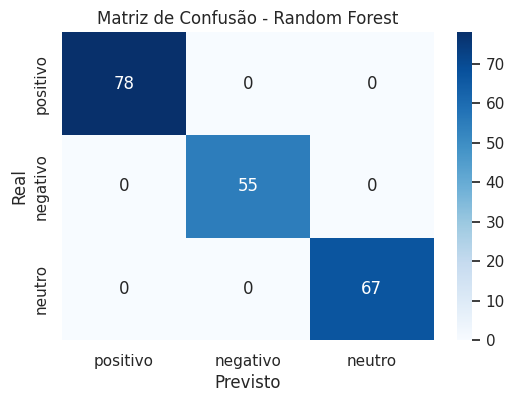

In [98]:
# Instanciar e treinar o modelo Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Previsões
y_pred = rf_model.predict(X_test)

# Exibir métricas de avaliação
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred))

# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=['positivo', 'negativo', 'neutro'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positivo', 'negativo', 'neutro'],
            yticklabels=['positivo', 'negativo', 'neutro'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

# Logistic Regression

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00        55
      neutro       1.00      1.00      1.00        67
    positivo       1.00      1.00      1.00        78

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



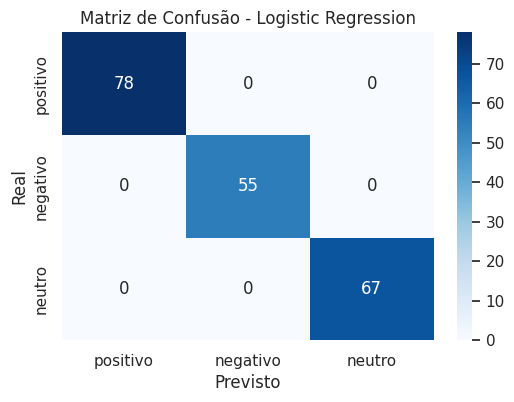

In [99]:
# Instanciar e treinar o modelo Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Previsões
y_pred = lr_model.predict(X_test)

# Exibir métricas de avaliação
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred))

# Criar matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=['positivo', 'negativo', 'neutro'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positivo', 'negativo', 'neutro'],
            yticklabels=['positivo', 'negativo', 'neutro'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Logistic Regression')
plt.show()